In [1]:
import pandas as pd
import numpy as np

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

In [3]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


In [4]:
df.isna().sum()/len(df)*100

dt                               0.000000
AverageTemperature               5.654225
AverageTemperatureUncertainty    5.526251
Country                          0.000000
dtype: float64

In [5]:
df_shape_old = df.shape[0]

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df_shape_new = df.shape[0]
print(f'Удалено: {df_shape_old - df_shape_new}')

Удалено: 32651


In [6]:
display(df.info())
display(df.describe())

display(df['Country'].describe())

<class 'pandas.core.frame.DataFrame'>
Index: 544811 entries, 0 to 577460
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             544811 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  544811 non-null  float64
 3   Country                        544811 non-null  object 
dtypes: float64(2), object(2)
memory usage: 20.8+ MB


None

,AverageTemperature,AverageTemperatureUncertainty
count,544811.000000,544811.000000
mean,17.193354,1.019190
std,10.953966,1.202634
min,-37.658000,0.052000
25%,10.025000,0.323000
50%,20.901000,0.571000
75%,25.814000,1.207000
max,38.842000,15.003000


count     544811
unique       242
top        Åland
freq        3166
Name: Country, dtype: object

In [7]:
df['dt'] = pd.to_datetime(df['dt'])

array([[<Axes: title={'center': 'dt'}>,
        <Axes: title={'center': 'AverageTemperature'}>],
       [<Axes: title={'center': 'AverageTemperatureUncertainty'}>,
        <Axes: >]], dtype=object)

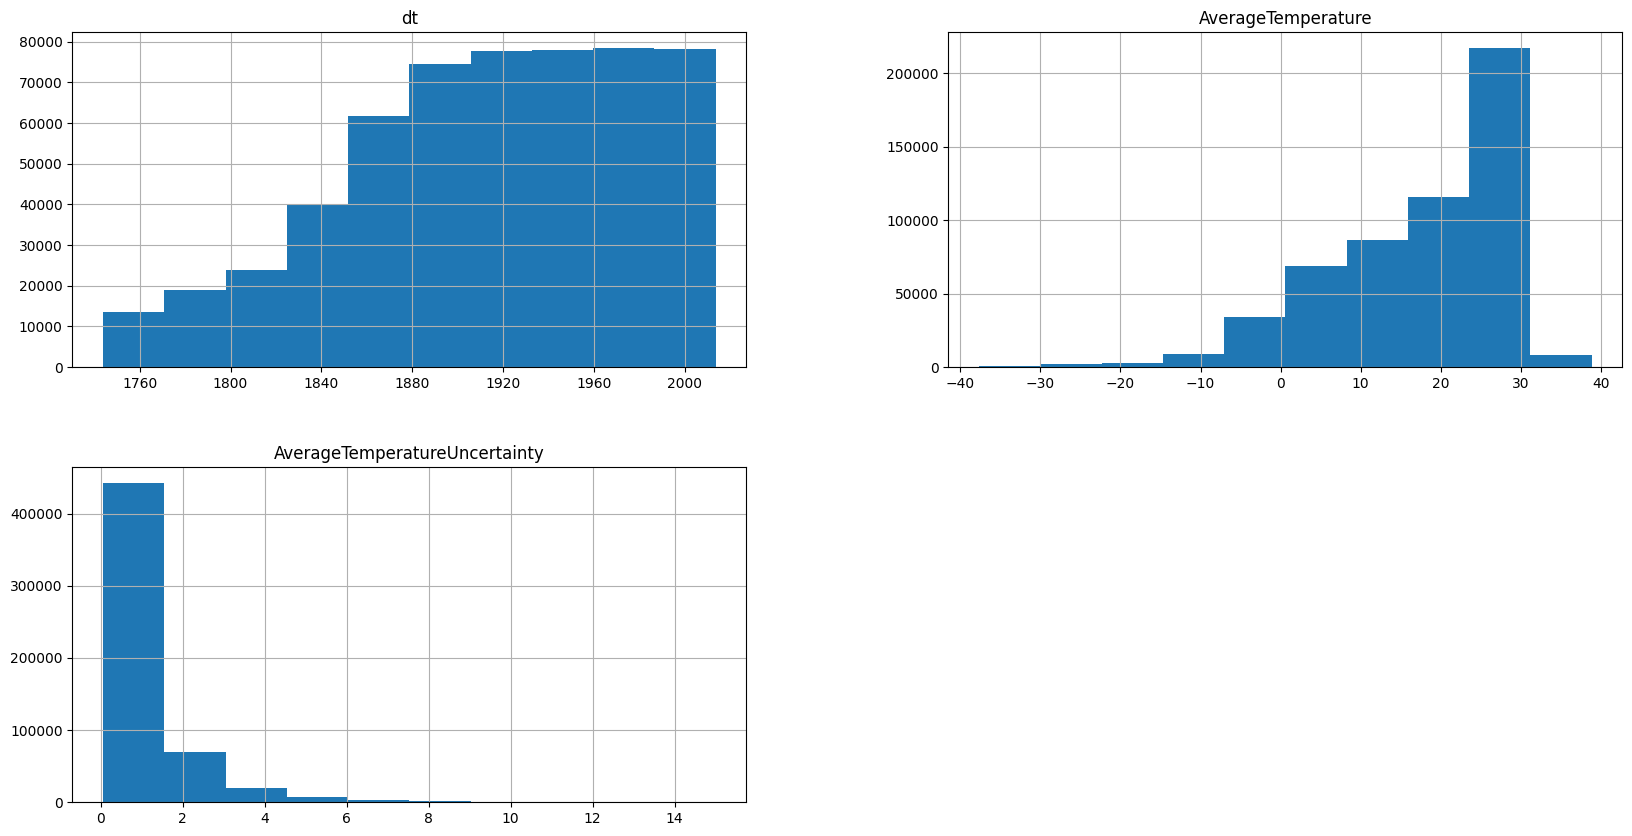

In [8]:
df.hist(figsize=(20, 10))

### Времянные ряды

#### 2.1 Импорт модулей

In [9]:
# Модели для прогнозирования
from statsmodels.tsa.arima.model import ARIMA

# Функция для разделения временного ряда на компоненты
from statsmodels.tsa.seasonal import seasonal_decompose

# Тест Дики-Фуллера (ADF) для определения стационарности
from statsmodels.tsa.stattools import adfuller

# Метрики для оценки качества прогнозов
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### 2.2 Подготовка данных

Так как в датасете средняя температура измеряется не для ондной старны, а для разных, значит, что нам нужно будет делать прогнозы для выбранной страны. Для этого мы инициализируем переменную в которой и будем хранить выбранную страну, чтобы не указывать её в функциях напрямую

In [10]:
country = 'Zimbabwe'

# Создаём новый датасет с измерениями температур только для текущей страны
df_new = df[df['Country'] == country]
# Устанавливаем дату в качестве индекса
df_new.set_index('dt', inplace=True)

# Так как данных довольно много, генеральная выборка будет состоять из измерений с начала 1950 года
df_new = df_new['1950-01-01':]
df_new

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1950-01-01,23.526,0.175,Zimbabwe
1950-02-01,24.089,0.296,Zimbabwe
1950-03-01,23.642,0.444,Zimbabwe
1950-04-01,22.258,0.369,Zimbabwe
1950-05-01,17.536,0.264,Zimbabwe
...,...,...,...
2013-04-01,21.142,0.495,Zimbabwe
2013-05-01,19.059,1.022,Zimbabwe
2013-06-01,17.613,0.473,Zimbabwe


Датасет с измерениями средней за месяц температуры с 1950 года для текущей страны успешно создан

Визуализируем получившейся временной ряд и заодно выведем скользящее среднее

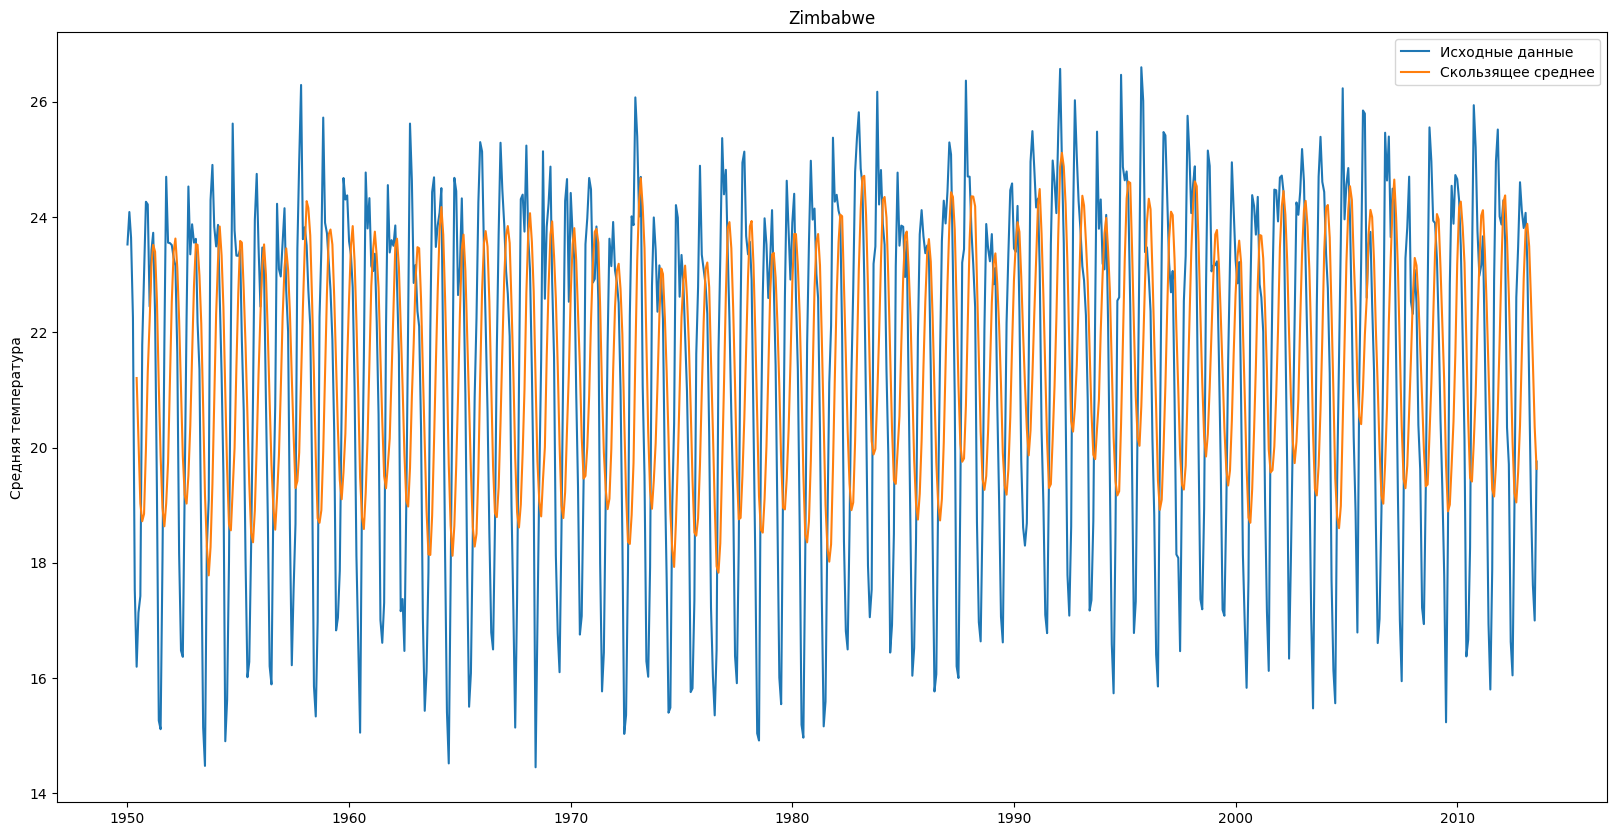

In [11]:
# Создаём контейнер
plt.figure(figsize=(20, 10))

# Строим график исходных данных и скользящего среднего
plt.plot(df_new['AverageTemperature'], label='Исходные данные')
plt.plot(df_new['AverageTemperature'].rolling(6).mean(), label='Скользящее среднее')

# Выводим прочую информацию и показываем график
plt.title(country)
plt.ylabel('Средняя температура')
plt.legend()
plt.show();

Можно заметить, что температура скачет в пределах 14-26 градусов, что скорее всего связано с переменной времён года

Чтобы обучить модели для прогнозирования, временной ряд должен быть стационарным (т.е. не иметь явного тренда, сезонности и т.п.).  
Для анализа стационарности, разделим временной ряд на соответствующие компоненты и для каждого построим график. 

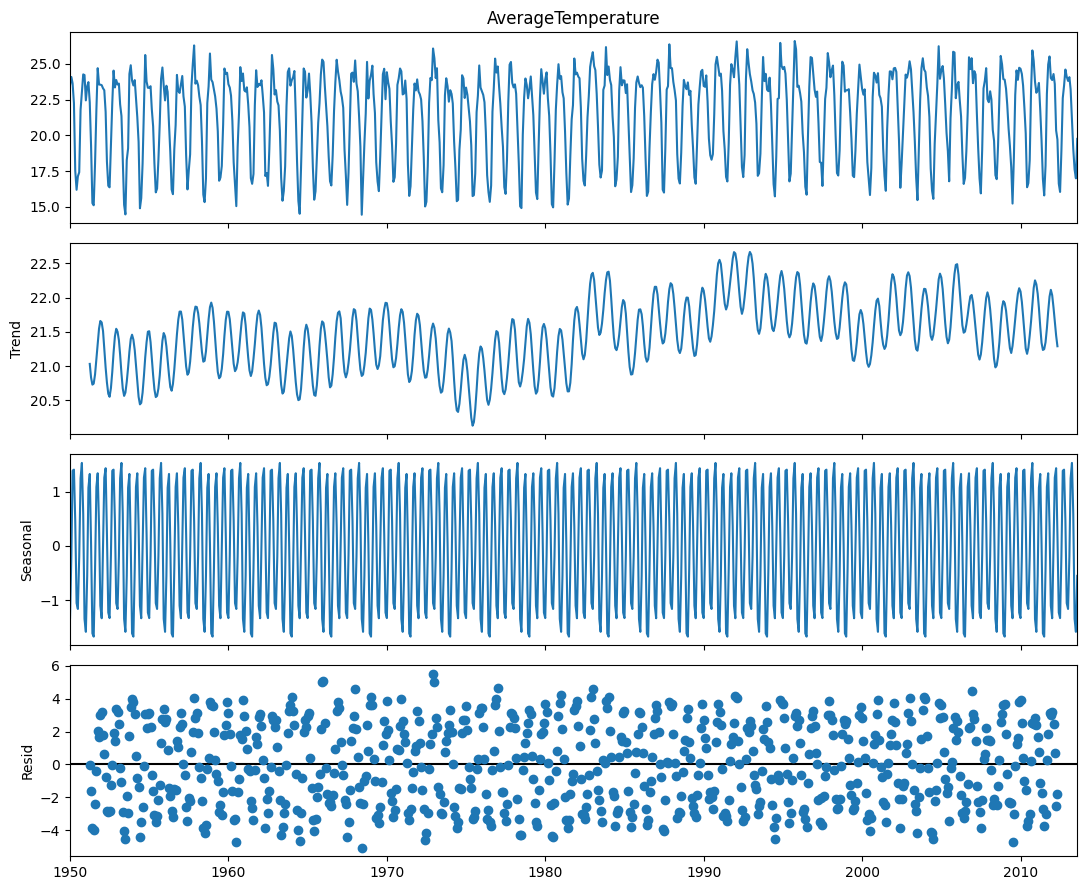

In [12]:
# Создаём контейнер
rcParams['figure.figsize'] = 11, 9

# Разделяем ряд на компоненты и строим график для каждого компонента
decompose = seasonal_decompose(df_new['AverageTemperature'], period=30, model='additive')
decompose.plot()

# Выводим график
plt.show();

Явного тренда и циклов не замечено, но, так как у температуры есть свойство меняться с пришествием нового времени года, есть некая сезонность.  
Чтобы точнее сказать, является ли ряд стационарным, проведём тест Дики-Фуллера. Что именно нам нужно получить, чтобы сказать стационарен ли ряд?  
Есть нулевая гипотеза в тесте, которая гласит, говоря просто, что ряд нестационарен. Нулевая гипотеза отметается тогда, когда p-значение по результатам теста ниже 0.05. 

In [13]:
# Проводим тест
res = adfuller(df_new['AverageTemperature'])

# Выводим p-значение
print(f'P-value - {res[0]}')

P-value - -4.946011357508366


В нашем случае нулевая гипотеза отвергается - ряд стационарен.

Так как никаких действий для достижения стационарности ряда проводить не требуется, сразу разделим датасет на тренировочный и тестовый набор, и определим насколько месяцев нужно будет сделать предсказание (размер тестовой выборки)

In [14]:
# Определяем тренировочную и тестовую выборки 
train_data = df_new['AverageTemperature'][:'2000-01-01']
test_data = df_new['AverageTemperature']['2000-02-01':]

# Определяем кол-во шагов для предсказания
forecast_steps = test_data = df_new['AverageTemperature']['2000-02-01':].shape[0]

#### ARIMA

Первая модель - ARIMA.  
Указываем тренировочный датасет и 3 целочисленных параметра

In [15]:
# Тренируем модель
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

# Выводи сводку
print(model_fit.summary())

C:\Users\Sergey\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Sergey\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Sergey\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Модель натренирована, а значит следующим шагом будет прогноз, так как шаги ранее уже были определены, сразу делаем прогноз и выводим среднюю абсолютную ошибку, чтобы оценить качество прогноза

In [18]:
forecast = model_fit.forecast(steps=forecast_steps)

mae = mean_absolute_error(test_data, forecast)
print(f'MAE - {mae}')

MAE - 2.4860866196522977


Ошибка составляет 2.5 градуса, что является средним показателем в данном датасете

Построим график, который покажет, насколько хорошо модель предсказала тестовую выборку

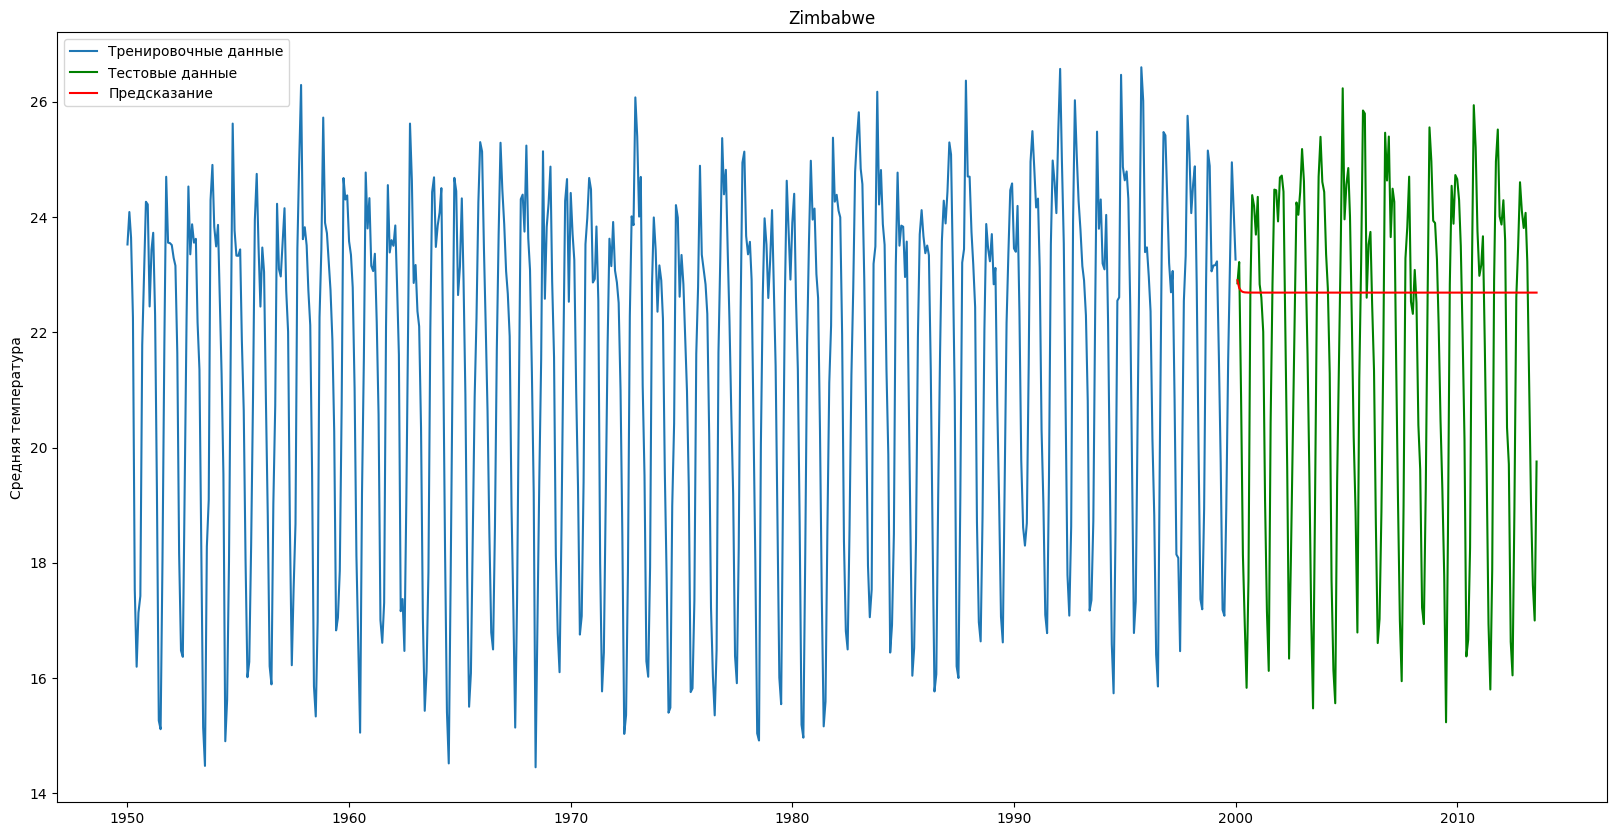

In [23]:
# Создаём контейнер
plt.figure(figsize=(20, 10))

# Строим графики тренировочных и тестовых данных, а также сам прогноз
plt.plot(df_new['AverageTemperature'][:'2000-01-01'], label='Тренировочные данные')
plt.plot(df_new['AverageTemperature']['2000-01-02':], label='Тестовые данные', color='green')
plt.plot(forecast, label='Предсказание', color='red')

# Выводим прочую информацию
plt.title(country)
plt.ylabel('Средняя температура')
plt.legend()
plt.show();

Невероятные результаты